In [1]:
import numpy as np
from numpy import linalg as LA

import pandas as pd
from math import sqrt, pi

from qiskit import *
from qiskit.visualization import plot_histogram, plot_distribution, plot_error_map, plot_bloch_multivector, plot_state_qsphere
from qiskit.visualization.array import array_to_latex
from qiskit.quantum_info import hellinger_fidelity, random_statevector, Statevector, Operator,QuantumState


from qiskit_ibm_provider import IBMProvider

from qiskit_aer import AerSimulator, QasmSimulator, StatevectorSimulator


# Plotting tools
import matplotlib.pyplot as plt

In [2]:
#IBMProvider.save_account("Your_Token", overwrite=True)
#provider = IBMProvider()

#수업을 위해 추가된 허브와 그룹, 프로젝트를 프로바이더에 설정
provider = IBMProvider(instance="ibm-q-yonsei/internal/qc-and-simulatio")

In [3]:
from qiskit_ibm_provider import least_busy

real_backend = least_busy(provider.backends())
real_backend

<IBMBackend('ibm_auckland')>

### 제 4 가설 - 다중 양자 상태(multiple quantum state)

지금까지는 하나의 양자상태만을 갖는 양자 시스템에 대해서 살펴보았습니다. 양자컴퓨터에 비교하자면 큐비트 하나로 이루어진 시스템이었습니다. 하지만 양자 시스템이 여러개의 양자시스템의 합성으로 이루어지는 경우, 2개 이상의 큐비트를 지닌 양자컴퓨터와 같은 경우, 어떻게 다루어야 할까요. 이와 같은 합성 시스템을 수학적으로 표현하는 방법을 알아보기 전, 합성 시스템의 차원에 대해 살펴봅시다.

두개의 큐비트로 이루어진 양자 시스템을 가정해 봅시다. 각각의 큐비트는 2차원의 양자 공간에 존재합니다. 두 개의 큐비트로 이루어진 양자 공간은 4차원의 단일 양자 시스템으로 볼 수있으며 그 근거는 다음과 같습니다. 각각의 큐비트는 배타적인 두 개의 상태($|0\rangle, |1\rangle$)를 지니고 있고 각 큐비트는 서로 구분이 가능하기 때문에 전체 시스템은 총 4개(첫번째 큐비트의 상태를 왼쪽에, 두번째 큐비트의 상태를 오른쪽에 남긴다고 할 때, 각각 $|00\rangle$, $|01\rangle$, $|10\rangle$, $|11\rangle$)의 배타적인 상태를 지닌 단일 시스템으로 해석할 수 있습니다.

#### 텐서곱(Tensor product)
다음과 같은 임의의 상태를 지니는 두개의 큐비트가 있다고 가정해 봅시다. 두개의 큐비트로 이루어진 시스템의 상태는 다음과 같이 텐서곱으로 계산할 수 있습니다.
$$
|a\rangle = a_0|0\rangle + a_1|1\rangle =
\begin{pmatrix}
a_0\\
a_1
\end{pmatrix}, |b\rangle = b_0|0\rangle + b_1|1\rangle =
\begin{pmatrix}
b_0\\
b_1
\end{pmatrix}
$$
$$
|ab\rangle = |a\rangle \otimes |b\rangle =
\begin{pmatrix}
a_0 \times
\begin{pmatrix}
b_0\\
b_1
\end{pmatrix}\\
a_1 \times
\begin{pmatrix}
b_0\\
b_1
\end{pmatrix}
\end{pmatrix} =
\begin{pmatrix}
a_0b_0\\
a_0b_1\\
a_1b_0\\
a_1b_1
\end{pmatrix}
$$
이 텐서곱을 새로 만들어질 시스템의 기저를 계산하기 위해 사용해 봅시다.
$$
|00\rangle = |0\rangle_{qubit_1}\otimes|0\rangle_{qubit_2}=
\begin{pmatrix}
1 \times 
\begin{pmatrix}
1\\
0
\end{pmatrix}
\\
0 \times 
\begin{pmatrix}
1\\
0
\end{pmatrix}
\end{pmatrix} =
\begin{pmatrix}
1\\
0\\ 
0\\ 
0
\end{pmatrix}$$

$$
|01\rangle = |0\rangle_{qubit_1}\otimes|1\rangle_{qubit_2}=
\begin{pmatrix}
1 \times 
\begin{pmatrix}
0\\
1
\end{pmatrix}
\\
0 \times 
\begin{pmatrix}
0\\
1
\end{pmatrix}
\end{pmatrix} =
\begin{pmatrix}
0\\
1\\ 
0\\ 
0
\end{pmatrix}$$

$$
|10\rangle = |1\rangle_{qubit_1}\otimes|0\rangle_{qubit_2}=
\begin{pmatrix}
0 \times 
\begin{pmatrix}
1\\
0
\end{pmatrix}
\\
1 \times 
\begin{pmatrix}
1\\
0
\end{pmatrix}
\end{pmatrix} =
\begin{pmatrix}
0\\
0\\ 
1\\ 
0
\end{pmatrix}$$

$$
|11\rangle = |1\rangle_{qubit_1}\otimes|1\rangle_{qubit_2}=
\begin{pmatrix}
0 \times 
\begin{pmatrix}
0\\
1
\end{pmatrix}
\\
1 \times 
\begin{pmatrix}
0\\
1
\end{pmatrix}
\end{pmatrix} =
\begin{pmatrix}
0\\
0\\ 
0\\ 
1
\end{pmatrix}$$

#### 측정 확률
여러 개의 양자 시스템이 결합된 시스템의 측정 확률은 어떻게 결정될까요? 각각의 양자 시스템의 상태들이 배타적이기 때문에 아주 간단하게도 합성 시스템의 상태 $|\Psi\rangle = |\phi_1\rangle|\phi_2\rangle = |\phi_1\rangle \otimes |\phi_2\rangle$의 측정 확률은 다음과 같이 결정됩니다.
$$P(\Psi) = P(\phi_1)P(\phi_2) = |\langle \phi_1 | \psi_1 \rangle|^2|\langle \phi_2 | \psi_2 \rangle|^2$$


다음의 셀에서 $|+\rangle$ 상태인 단일 큐비트 3개로 구성된 다중 큐비트 회로를 작성하고, 그 회로의 상태벡터를 확인해 봅시다. 또한 상태벡터를 bloch 구면으로 확인해 봅시다.

In [5]:
qc = QuantumCircuit(3)
qc.h(range(3))
state = Statevector(qc)
array_to_latex(state)

<IPython.core.display.Latex object>

In [6]:
#measure result
state.sample_counts(shots=10000)

{'000': 1251,
 '001': 1330,
 '010': 1249,
 '011': 1277,
 '100': 1201,
 '101': 1225,
 '110': 1256,
 '111': 1211}

In [7]:
#probability
state.probabilities_dict()

{'000': 0.12499999999999994,
 '001': 0.12499999999999994,
 '010': 0.12499999999999994,
 '011': 0.12499999999999994,
 '100': 0.12499999999999994,
 '101': 0.12499999999999994,
 '110': 0.12499999999999994,
 '111': 0.12499999999999994}

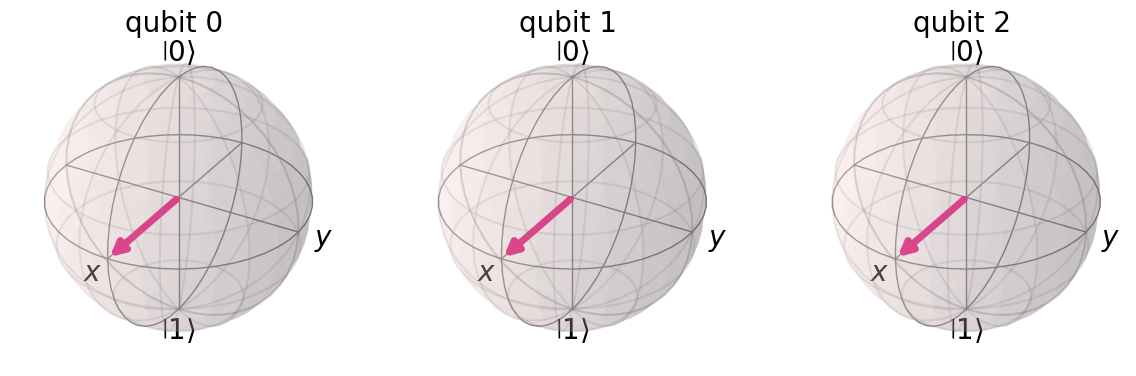

In [8]:
state.draw('bloch')

## 연습문제
1. Write down the kronecker product of the qubits:
- a)$|0\rangle |1\rangle$
- b)$|0\rangle |+\rangle$ 
- c)$|+\rangle |1\rangle$ 
- d)$|-\rangle |+\rangle$ 


2. Write the state: $|\psi\rangle = \frac{1}{\sqrt{2}}|00\rangle + \frac{i}{\sqrt{2}}|01\rangle$ as two separate qubits.

In [9]:
# prepare ingredient
ket0 = Statevector([]).from_label('0')
display(array_to_latex(ket0))
ket1 = Statevector([]).from_label('1')
display(array_to_latex(ket1))
ketp = Statevector([]).from_label("+")
display(array_to_latex(ketp))
ketm = Statevector([]).from_label('-')
display(array_to_latex(ketm))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Qiskit에서 statevector들의 tensor곱은
- ^ (ex: a^b)
를 사용해 쉽게 구할수있습니다

In [10]:
#1-a
array_to_latex(ket0^ket1)

<IPython.core.display.Latex object>

In [11]:
#1-b
array_to_latex(ket0^ketp)

<IPython.core.display.Latex object>

In [12]:
#1-c
array_to_latex(ketp^ket1)

<IPython.core.display.Latex object>

In [13]:
#1-d
array_to_latex(ketm^ketp)

<IPython.core.display.Latex object>

$|\psi\rangle = \frac{1}{\sqrt{2}}|00\rangle + \frac{i}{\sqrt{2}}|01\rangle =|0\rangle \otimes (\frac{1}{\sqrt{2}}|0\rangle + \frac{i}{\sqrt{2}}|1\rangle)$

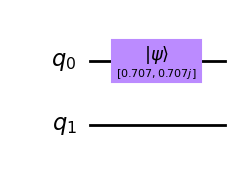

In [14]:
qc = QuantumCircuit(2)
init = [sqrt(1/2), 1j*sqrt(1/2)]
qc.initialize(init, 0)
qc.draw('mpl')

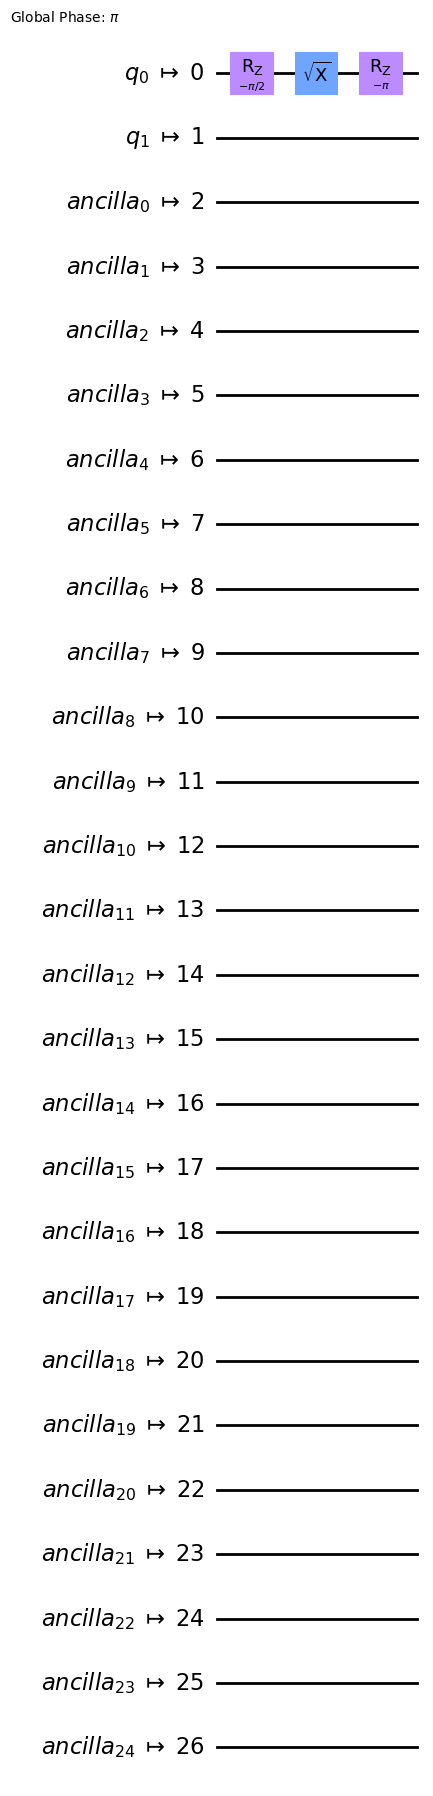

In [15]:
qc_tr = transpile(qc, real_backend)
qc_tr.draw('mpl')

## 2. Single Qubit Gates on Multi-Qubit Statevectors

Qubit0는 Hadamard Gate가, Qubit1은 X Gate가 각각 적용된 2큐비트 양자회로를 그리고, 이 회로의 Operator를 확인해 봅시다.

In [16]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
array_to_latex(Operator(qc).to_instruction())

<IPython.core.display.Latex object>

## 연습문제
1. Calculate the single qubit unitary (U) created by the sequence of gates: U=XZH. 
2. Use Qiskit's Aersimulator to check your results.

In [17]:
#1

qc = QuantumCircuit(2)
qc.h(0)
qc.z(0)
qc.x(0)
array_to_latex(Operator(qc))

<IPython.core.display.Latex object>

In [19]:
qc.save_unitary()

In [20]:
backend = AerSimulator()
result = backend.run(qc).result().get_unitary()
array_to_latex(result)


<IPython.core.display.Latex object>

## 3. Multi-Qubit Gates

### CNOT-Gate

고전 컴퓨터의 논리게이트 중 XOR 게이트의 논리표는 다음과 같습니다.

|input1 (Control bit)|input2 (Target bit)|output = input2|
|---|---|---|
|0 | 0| 0 |
|0 | 1 | 1 |
| 1| 0 | 1|
|1 | 1 | 0|

<img src="https://learn.qiskit.org/content/v2/ch-states/images/cnot_xor.svg" alt="Alternative text" width=300/>

아래에서 H 게이트와 CNOT 게이트로 작성된 간단한 양자 회로를 작성하고 단계마다 큐비트의 statevector와 양자게이트의 operator를 확인해 봅시다./


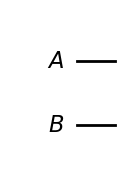

In [21]:
A = QuantumRegister(1, "A")
B = QuantumRegister(1, "B")
circuit = QuantumCircuit(A, B)
circuit.draw("mpl")

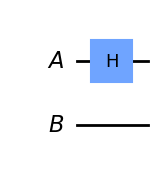

In [22]:
circuit.h(A)
circuit.draw('mpl')

In [23]:
array_to_latex(Operator(circuit))

<IPython.core.display.Latex object>

In [24]:
array_to_latex(Statevector(circuit))

<IPython.core.display.Latex object>

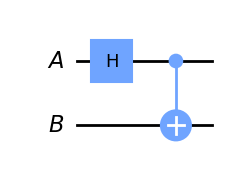

In [25]:
circuit.cx(A, B)
circuit.draw("mpl")

In [26]:
array_to_latex(Operator(circuit))

<IPython.core.display.Latex object>

In [27]:
array_to_latex(Statevector(circuit))

<IPython.core.display.Latex object>

## 3.2 Entangled States

바로 위에서 만든 양자 회로의 Statevector를 살펴봅시다. 이 상태는
$$\frac{\sqrt{2}}{2}(|00\rangle + |11\rangle)$$
 
와 같이 쓸수 있으며, $|00\rangle$과 $|11\rangle$을 측정할 확률이 각각 50%이며, $|01\rangle$과 $|10\rangle$을 측정할 확률은 0이 됩니다. 

Statevector를 사용하여 결과를 실제로 구현해 봅시다.

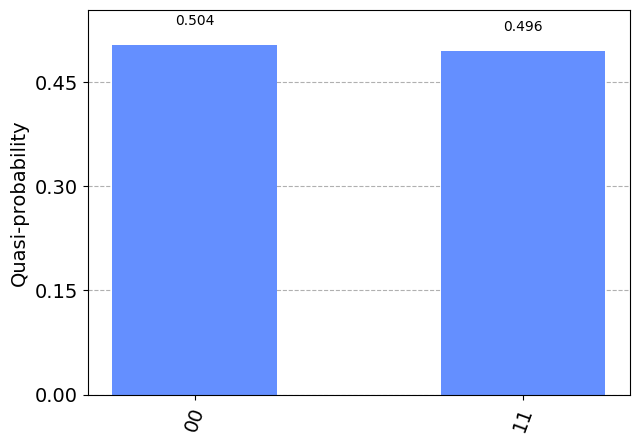

In [28]:
backend = AerSimulator()
circuit.measure_all()
job = backend.run(circuit, shots=10000) #shot
results = job.result()
counts = results.get_counts()

plot_distribution(counts)

이 상태의 신기함을 다음의 회로로 다시 확인해 봅시다. 이 회로는 0번 큐비트 만을 측정하여 상태가 결정되게 됩니다. 측정이 있기 전과 후의 큐비트의 statevector를 확인하여 두 큐비트가 얽혀있음을 확인해 봅시다.

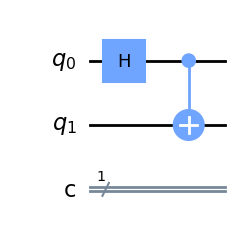

In [29]:
qc=QuantumCircuit(2,1)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

In [30]:
array_to_latex(Statevector(qc))

<IPython.core.display.Latex object>

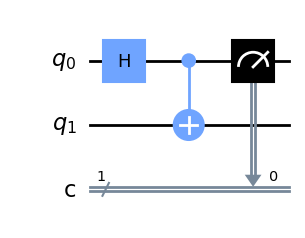

In [31]:
qc=QuantumCircuit(2,1)
qc.h(0)
qc.cx(0,1)
qc.measure(0,0)
qc.draw('mpl')

In [32]:
backend = StatevectorSimulator()
result= backend.run(qc, shots=1).result()
result.get_counts()

{'0': 1}

In [33]:
array_to_latex(result.get_statevector())

<IPython.core.display.Latex object>

## 3.3 Visualizing Entangled States

얽힌 상태를 효과적으로 표시하는 것은 어려운 일입니다. Qiskit의 두가지 모듈이 다중 큐비트 상태의 표현을 지원합니다. 여러분이 이미 친숙하신 함수들입니다.

다음과 같은 얽힘 상태를 갖는 회로를 만들고 plot_bloch_multivector와 qspher를 사용해 그려보세요.

|$\Psi^+$> = [0.      +0.j, 0.707107+0.j, 0.707107+0.j ,0.      +0.j]

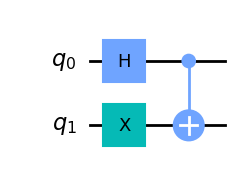

In [34]:
qc_psi_plus = QuantumCircuit(2)

qc_psi_plus.x(1)
qc_psi_plus.h(0)
qc_psi_plus.cx(0,1)

qc_psi_plus.draw(output='mpl')

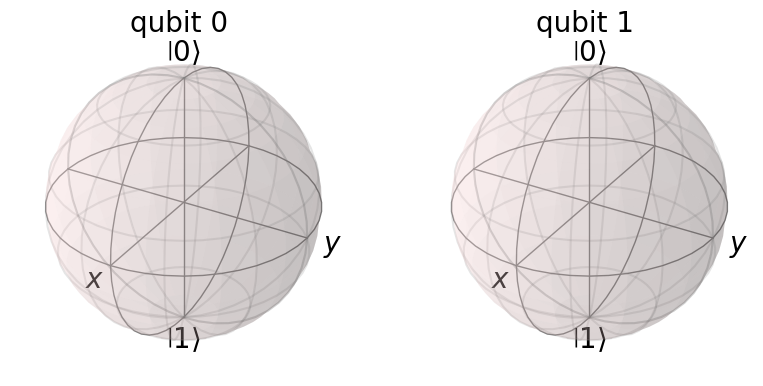

In [35]:
plot_bloch_multivector(Statevector(qc_psi_plus))

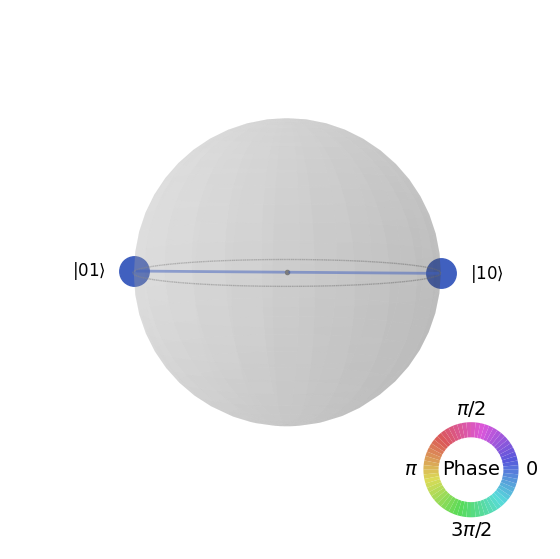

In [36]:
 plot_state_qsphere(Statevector(qc_psi_plus))

# Phase Kickback

## How we use the global phase

전역 위상은 일반적으로 측정에 아무 영향을 미치지 않기 때문에 중요하지 않게 여겨지곤 합니다.

$|\psi\rangle \rightarrow e^{i\alpha}|\psi\rangle $에 대하여, $|\langle\phi|\psi\rangle|^2 \rightarrow |e^{i\alpha}\langle\phi|\psi\rangle|^2 = |e^{i\alpha}|^2|\langle\phi|\psi\rangle|^2 = |\langle\phi|\psi\rangle|^2$

하지만, 다음과 같은 다중 큐비트 연산을 정의할 때 어떤 일이 발생하는 지 한번 살펴봅시다:
$V_\alpha = e^{i\alpha}I$ 는 아주 간단히 대상에 전역 위상을 부여하는 동작을 합니다. 이 연산을 사용한 제어 연산을 정의하게 되면, 그 결과는 다음과 같이 다소 흥미롭습니다:
$$|0\rangle\langle0|\otimes I + |1\rangle\langle1|\otimes e^{i\alpha}I = 
\begin{pmatrix}
1 & 0\\
0 & e^{i\alpha}
\end{pmatrix} \otimes I
$$
위에서 볼 수 있듯이, 전역 위상이 제어 비트에 적용됩니다. 이것이 위상 반동의 아주 기본적인 개념입니다. 만약 우리가 제어된 U 연산을 U의 **eigenstate**를 지닌 큐비트 $|\psi_k\rangle$에 적용하면, $|\psi_k\rangle$의 상태는 변하지 않으면서 $|0\rangle\langle0|\otimes I + |1\rangle\langle1|\otimes e^{i\alpha}I$ 가 발생해서 제어 큐비트에 위상이 입혀지게 됩니다.

## Exploring the CNOT-Gate

텍스트북과 같은 순서로 CNOT 게이트를 탐색해 보고, Phase Kickback에 대해서 배워 보도록 합시다.

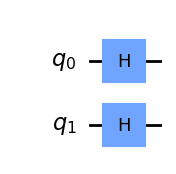

In [37]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.draw('mpl')

In [38]:
array_to_latex(Statevector(qc))

<IPython.core.display.Latex object>

In [39]:
qc.cx(0,1)
array_to_latex(Statevector(qc))

<IPython.core.display.Latex object>

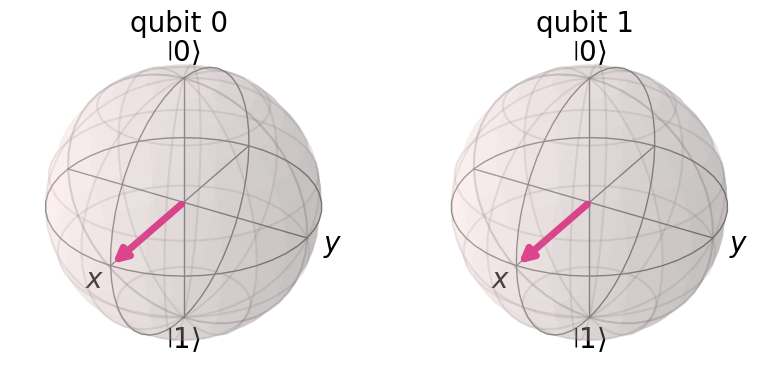

In [40]:
Statevector(qc).draw('bloch')

이번엔 대상 큐비트의 상태를 $|-\rangle$ 상태로 만든 후 CNOT 게이트를 적용해 봅시다.

In [41]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.h(1)
array_to_latex(Statevector(qc))

<IPython.core.display.Latex object>

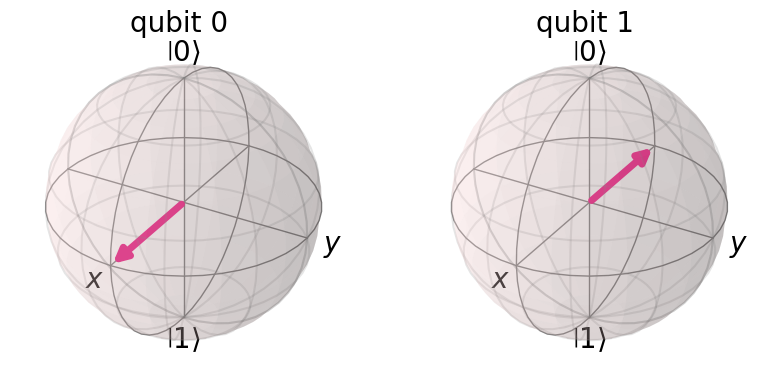

In [42]:
Statevector(qc).draw('bloch')

In [43]:
qc.cx(0,1)
array_to_latex(Statevector(qc))

<IPython.core.display.Latex object>

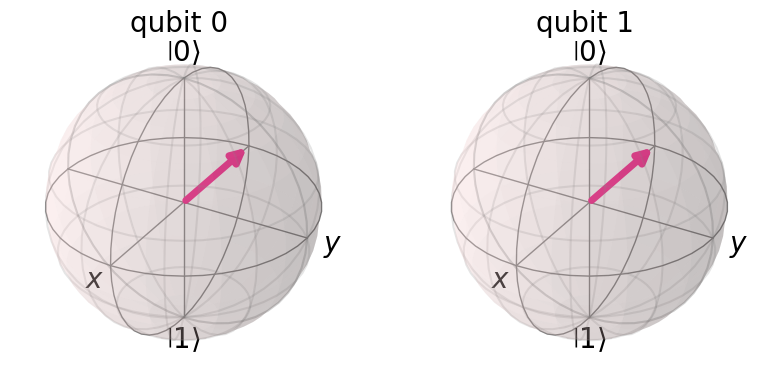

In [44]:
Statevector(qc).draw('bloch')

###  Circuit identity

Phase Kick-back을 이해하는 또다른 방법은 회로 자체의 특성을 이해하는 것입니다. 다음과 같이 Phase Kickback 회로중 일부분을 그려봅시다.

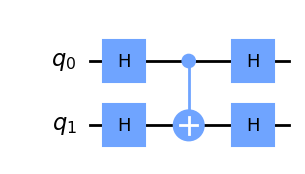

In [45]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.h(0)
qc.h(1)
qc.draw('mpl')

In [46]:
array_to_latex(Operator(qc))

<IPython.core.display.Latex object>

In [47]:
qc = QuantumCircuit(2)
qc.cx(1,0)
array_to_latex(Operator(qc))

<IPython.core.display.Latex object>

###   Kickback with the Phase Gate

Phase Kick-back은 기본적으로 제어된 유니터리 연산을 eigenstate인 큐비트에 적용할때 발생합니다. 우리는 앞서 각 pauli 연산의 eigenvector를 확인한 바 있으며, 가장 기본적이었던 Z 게이트의 eigenstate는 계산기저와 같은 $|0\rangle$ 또는 $|1\rangle$ 임을 앞서 확인했습니다. 

그렇다면! Z Gate와 같은 류의, Phase Gate를 Phase Kickback에 사용할 방법이 떠오르네요!

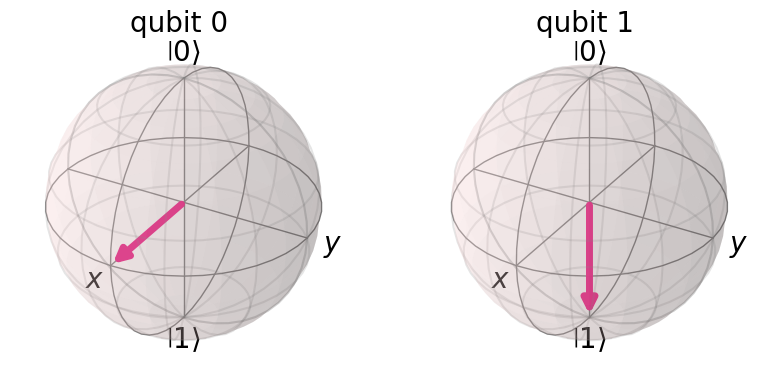

In [48]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
Statevector(qc).draw('bloch')


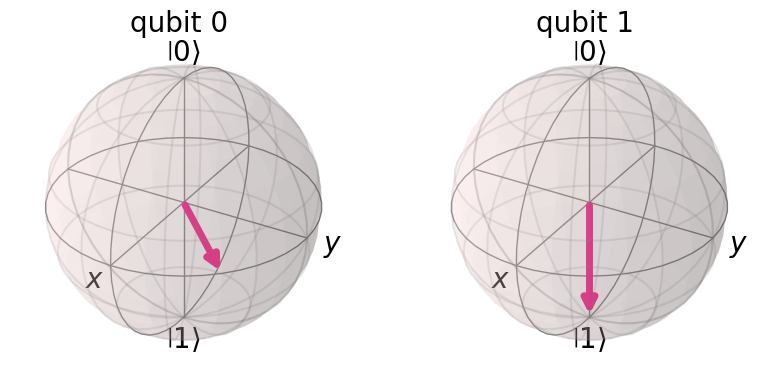

In [58]:
qc.cp(pi/4, 0, 1)
Statevector(qc).draw('bloch')

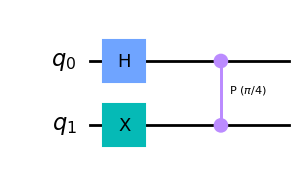

In [50]:
 qc.draw('mpl')

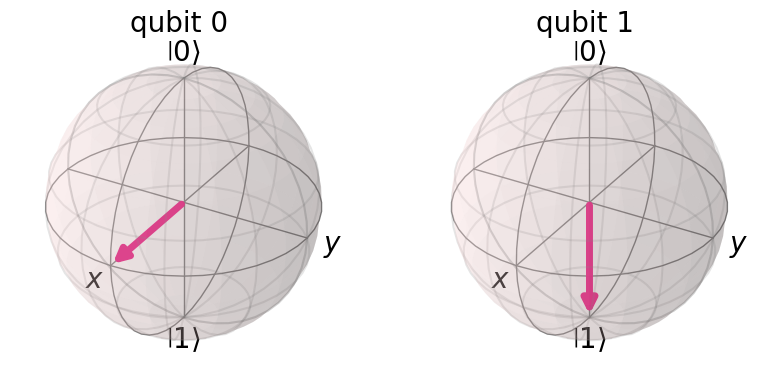

In [68]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
Statevector(qc).draw('bloch')


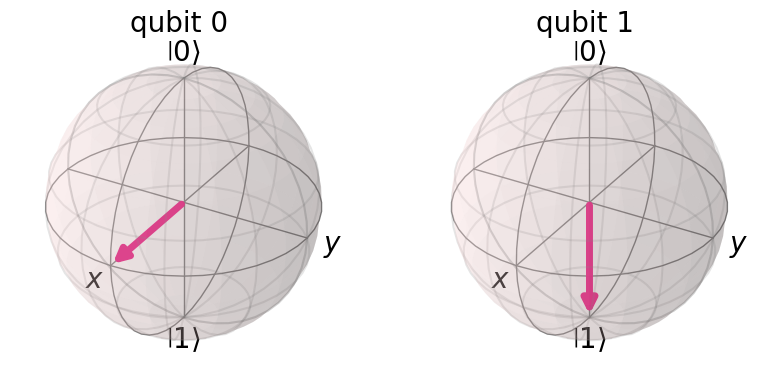

In [72]:
qc.cp(-pi/2, 0, 1)
Statevector(qc).draw('bloch')

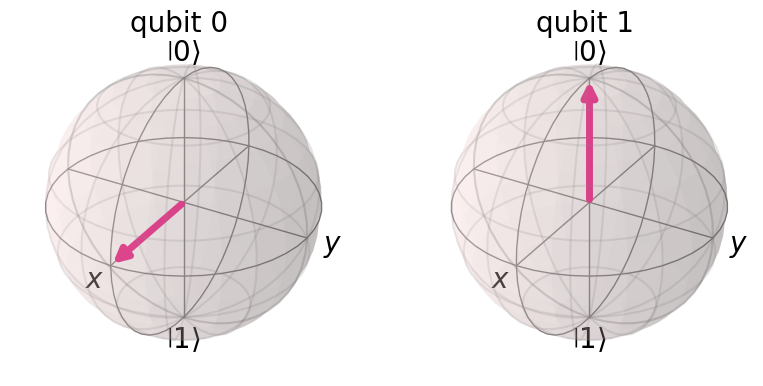

In [65]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cp(pi/2,0,1)
Statevector(qc).draw('bloch')

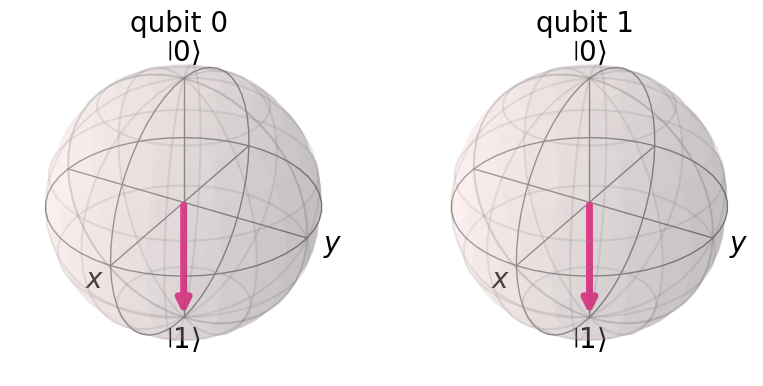

In [242]:
qc.cp(pi/4, 0, 1)
Statevector(qc).draw('bloch')

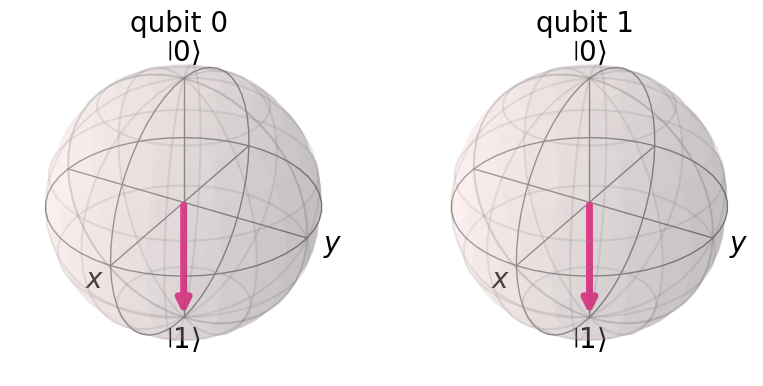

In [73]:
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
Statevector(qc).draw('bloch')

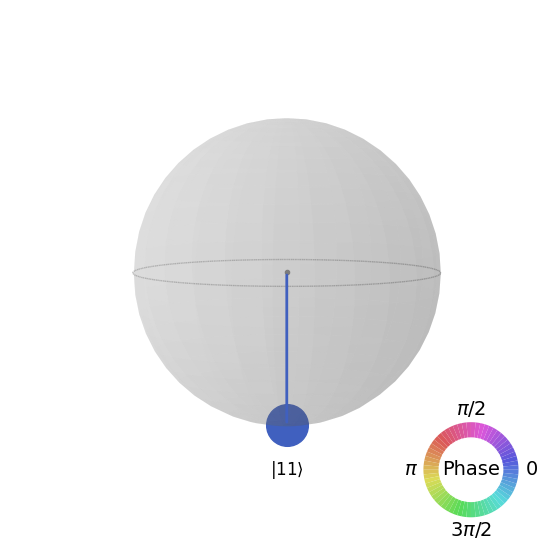

In [75]:
qc.cp(pi/4, 0, 1)
Statevector(qc).draw('qsphere')